In [14]:
import numpy as np 
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import data_prep as dp

In [2]:
X_train, X_val, X_test, y_train, y_val, y_test = \
    dp.X_train, dp.X_val, dp.X_test, dp.y_train, dp.y_val, dp.y_test

Ensemble models create `n_estimators` number of Decision Tree models, each model gets own set of features to train model. The final result is the average of all models.

In [5]:
# n_estimators -> number of models that will be trained
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7826433121019108

In [11]:
scores = []
# iterate through estimators
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    scores.append((n, roc_auc_score(y_val, y_pred)))

In [13]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores.sort_values(by='auc', ascending=False).head()

,n_estimators,auc
18,190,0.824447
17,180,0.824223
12,130,0.824172
10,110,0.824108
9,100,0.824039


<Axes: title={'center': 'Number of models vs AUC score'}, xlabel='n_estimators'>

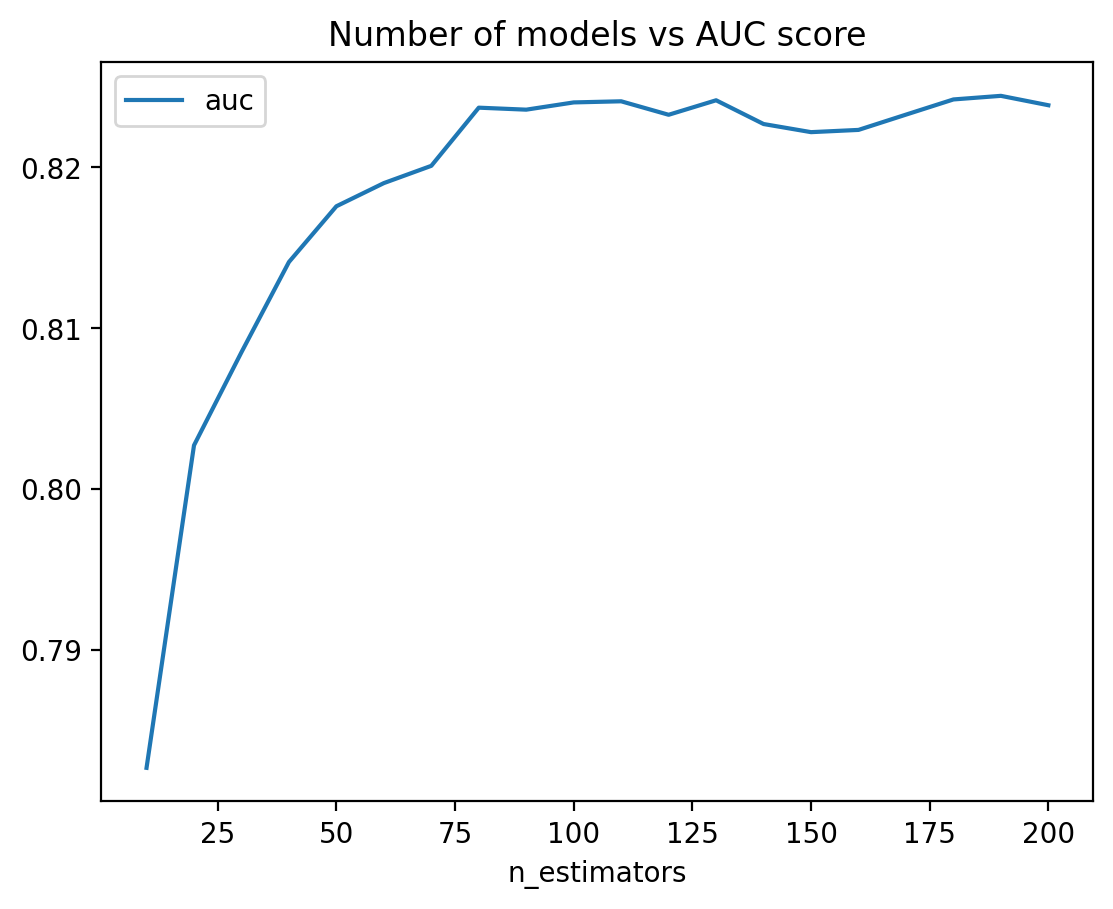

In [15]:
df_scores.plot(x='n_estimators', y='auc', title='Number of models vs AUC score')

The score is relatively the same after 80 estimators.

In [23]:
# train the model with max_depth

scores = []
# iterate through max_depth and estimators
for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d, 
                                    random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        scores.append((d, n, roc_auc_score(y_val, y_pred)))

In [24]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,n_estimators,auc
27,10,80,0.827617
28,10,90,0.827423
29,10,100,0.827205
34,10,150,0.826987
35,10,160,0.826963


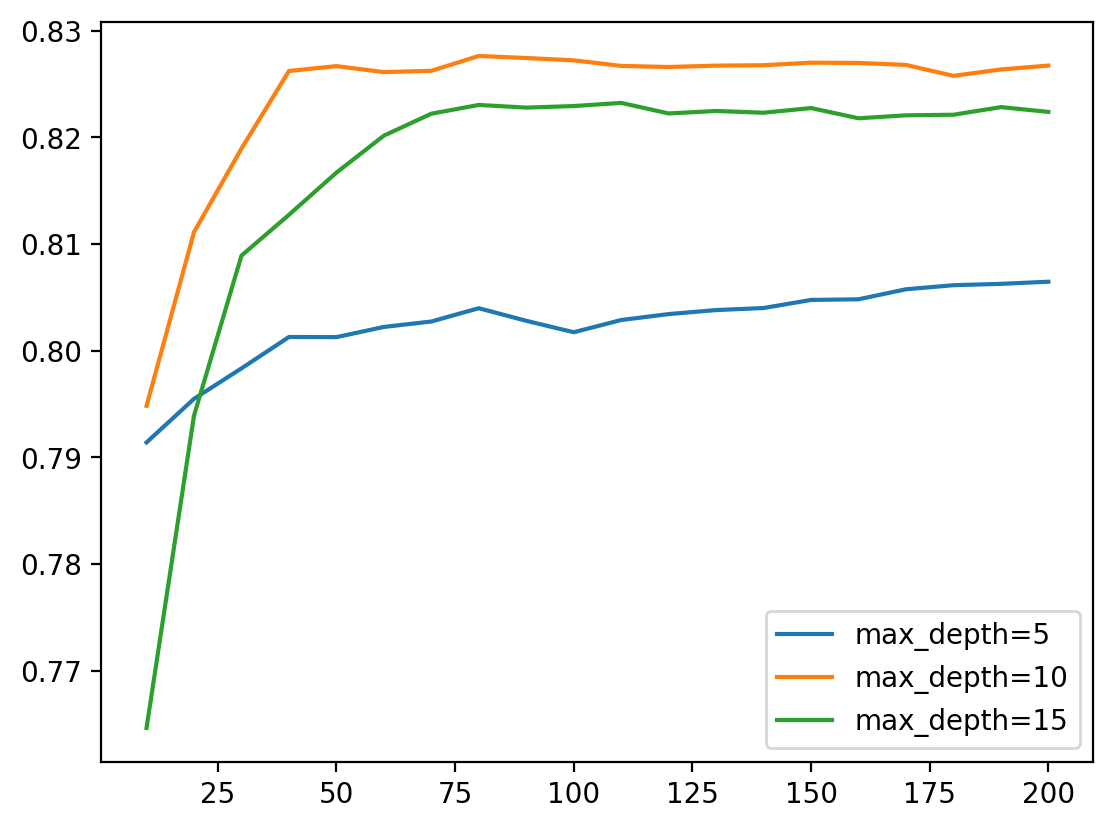

In [25]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset['n_estimators'], df_subset['auc'], label='max_depth=%d' % d)
plt.legend()
plt.show()

In [36]:
df_scores.query('max_depth == 10 and n_estimators >= 30 and n_estimators <= 50')

,max_depth,n_estimators,auc
22,10,30,0.818935
23,10,40,0.826206
24,10,50,0.826666


Now, the best results are performed with `max_depth=10` and there is no significant increase in score after 50 estimators. Let's check the `min_samples_leaf` parameter.

In [37]:
# set max_depth = 10
max_depth = 10

In [43]:
# tune min_samples_leaf

scores = []
# iterate through max_depth and estimators
for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth, 
                                    min_samples_leaf = s,
                                    random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        scores.append((s, n, roc_auc_score(y_val, y_pred)))

In [44]:
df_scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'n_estimators', 'auc'])
df_scores.sort_values(by='auc', ascending=False).head()

,min_samples_leaf,n_estimators,auc
28,3,90,0.828695
31,3,120,0.828604
30,3,110,0.828573
29,3,100,0.828422
33,3,140,0.827980


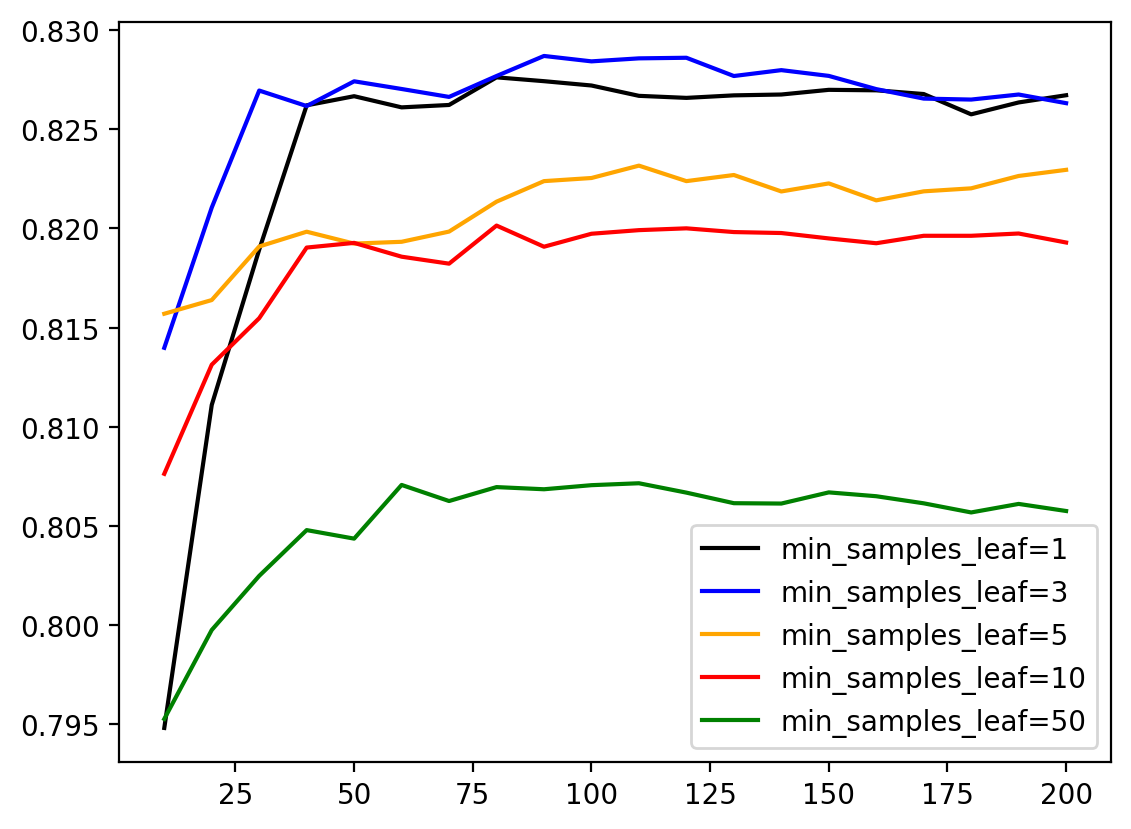

In [46]:
colors = ['black', 'blue', 'orange', 'red', 'green']
min_samples_leaf_values = [1, 3, 5, 10, 50]
for s, c in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset['n_estimators'], df_subset['auc'], 
                color = c,
                label='min_samples_leaf=%d' % s)
plt.legend()
plt.show()

In [47]:
# assign3 to  min_samples_leaf 
min_samples_leaf = 3

1 and 3 are the best values for `min_samples_leaf` parameter

Other parameters:
- `max_features`
- `bootstrap` if `False` -> uses whole dataset for the training. Default is `True`.
- `n_jobs` -> train in parallel. if `n_jobs = -1` training finishes faster as using all processers


What is Bagging?

- from [here](https://vitalflux.com/bagging-vs-boosting-machine-learning-methods/)

Bagging, short for “__bootstrap aggregating__”, is a method that can be used to improve the accuracy of your machine learning models. The idea behind bagging is to train multiple models on different subsets of the data and then combine the predictions of those models. The data is split into a number of smaller datasets, or “bags”, and individual models are trained on on each one. The models are then combined to produce a final prediction.  Bagging is important in machine learning because it helps to reduce variance and improve the accuracy of predictions. When a machine learning algorithm is trained on a single data set, its performance can vary significantly depending on the composition of that data set. By training the algorithm on multiple data sets (each of which is a “bag” of data), Bagging can help to reduce the variation in the final predictions. This, in turn, results in more accurate predictions overall.

In [49]:
# final Random Forest model
rf = RandomForestClassifier(n_estimators=90,
                            max_depth=10, 
                            min_samples_leaf=3,
                            random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=90,
                       random_state=42)